In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten, Input
from tensorflow.keras.models import Model
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from tabnet_keras import TabNetRegressor, TabNetClassifier





In [2]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../../../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
# from libs.common import *

c:\Users\PC\Data\ads_fraud_detection
c:/Users/PC/Data/ads_fraud_detection


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print('Using GPU:', gpus[0])  # In ra tên của GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
else:
    print('No GPU found. Using CPU.')

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
save_dir=f"{exps_dir}/exp2/exp_base"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [5]:
# feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
# feature_selection = {key: value for key, value in feature_selection.item().items()}
# feature_selection

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [6]:
# bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
# rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
# svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [7]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [8]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse_output=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(5089, 2) (10331, 2)


In [9]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(5089, 2)


In [10]:
x_test.shape

(5089, 33)

In [11]:
x_train.shape

(10331, 33)

In [12]:
def f1_score(y_true, y_pred):
    """
    Macro F1 score metric.
    """
    y_pred = K.round(y_pred)    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    false_positives = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)), axis=0)
    false_negatives = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)), axis=0)    
    precision = true_positives / (true_positives + false_positives + K.epsilon())
    recall = true_positives / (true_positives + false_negatives + K.epsilon())    
    f1_scores = 2 * (precision * recall) / (precision + recall + K.epsilon())    
    macro_f1_score = K.mean(f1_scores)
    
    return macro_f1_score

In [13]:
print(x_train.shape[1])

33


#### * Xây dựng model:

#### * Xây dựng Stacked_model:

In [14]:
def f1_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate true positives, predicted positives, and possible positives for each class
    tp = tf.reduce_sum(y_true * y_pred, axis=0)
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    possible_positives = tf.reduce_sum(y_true, axis=0)
    
    # Calculate precision and recall for each class
    precision = tp / (predicted_positives + tf.keras.backend.epsilon())
    recall = tp / (possible_positives + tf.keras.backend.epsilon())
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    
    # Calculate the macro F1 score
    f1_macro = tf.reduce_mean(f1)
    
    # Return the F1 loss
    return 1 - f1_macro

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [16]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Reshape, GlobalAveragePooling1D,MaxPooling1D,Dense,AveragePooling1D
from keras.models import Model
from keras import layers

from keras.layers import Layer
from keras import backend as K


WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


def conv1d_bn(x,
              filters,
              kernel_size,
              padding='same',
              strides=1,
              name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    bn_axis = 1
    x = Conv1D(
        filters, kernel_size,
        strides=strides,
        padding=str(padding),
        use_bias=False,
        name=conv_name)(x)
    x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    x = Activation('relu', name=name)(x)
    return x

In [17]:
def InceptionV3():
    # Determine proper input shape
    input_shape = (33,1)
    x_input = Input(shape=input_shape)
    channel_axis = -1

    x = conv1d_bn(x_input, 32, 3, strides=2, padding='valid')
    x = conv1d_bn(x, 32, 3, padding='valid')
    x = conv1d_bn(x, 64, 3, padding='valid')
    x = MaxPooling1D(3, strides=2, name="block1_pool")(x)
    # mixed 0, 1, 2: 35 x 35 x 256
    branch1x1 = conv1d_bn(x, 64,1,padding='same')

    branch5x5 = conv1d_bn(x, 48,1,padding='same')
    branch5x5 = conv1d_bn(branch5x5, 64, 5,padding='same')
    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 32, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed0')

    # mixed 1: 35 x 35 x 256
    branch1x1 = conv1d_bn(x, 64,1,padding='same')
    branch5x5 = conv1d_bn(x, 48, 1,padding='same')
    branch5x5 = conv1d_bn(branch5x5, 64,5,padding='same')

    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 64, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed1')

    # mixed 2: 35 x 35 x 256
    branch1x1 = conv1d_bn(x, 64, 1,padding='same')

    branch5x5 = conv1d_bn(x, 48, 1,padding='same')
    branch5x5 = conv1d_bn(branch5x5, 64, 5,padding='same')

    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 64, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch5x5, branch3x3dbl, branch_pool],
        axis=channel_axis,
        name='mixed2')

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv1d_bn(x, 128, 3, strides=2, padding='valid')

    branch3x3dbl = conv1d_bn(x, 64, 1,padding='same')
    branch3x3dbl = conv1d_bn(branch3x3dbl, 96, 3,padding='same')
    branch3x3dbl = conv1d_bn(
        branch3x3dbl, 96, 3, strides=2, padding='valid')

    branch_pool = MaxPooling1D(3, strides=2)(x)
    x = layers.concatenate(
        [branch3x3, branch3x3dbl, branch_pool], axis=channel_axis, name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv1d_bn(x, 128, 1,padding='same')

    branch7x7 = conv1d_bn(x, 96, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 96, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 128, 7,padding='same')

    branch7x7dbl = conv1d_bn(x, 96, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 96, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 96, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 96, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 128, 1,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 128, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed4')

    # # mixed 5, 6: 17 x 17 x 768
    # for i in range(2):
    #     branch1x1 = conv1d_bn(x, 192, 1,padding='same')

    #     branch7x7 = conv1d_bn(x, 160, 1,padding='same')
    #     branch7x7 = conv1d_bn(branch7x7, 160, 1,padding='same')
    #     branch7x7 = conv1d_bn(branch7x7, 192, 7,padding='same')

    #     branch7x7dbl = conv1d_bn(x, 160, 1,padding='same')
    #     branch7x7dbl = conv1d_bn(branch7x7dbl, 160, 7,padding='same')
    #     branch7x7dbl = conv1d_bn(branch7x7dbl, 160, 1,padding='same')
    #     branch7x7dbl = conv1d_bn(branch7x7dbl, 160, 7,padding='same')
    #     branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')

    #     branch_pool = AveragePooling1D(
    #         3, strides=1, padding='same')(x)
    #     branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
    #     x = layers.concatenate(
    #         [branch1x1, branch7x7, branch7x7dbl, branch_pool],
    #         axis=channel_axis,
    #         name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv1d_bn(x, 192, 1,padding='same')

    branch7x7 = conv1d_bn(x, 192, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 192, 1,padding='same')
    branch7x7 = conv1d_bn(branch7x7, 192, 7,padding='same')

    branch7x7dbl = conv1d_bn(x, 192, 1,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 7,padding='same')
    branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')
    # branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 7,padding='same')
    # branch7x7dbl = conv1d_bn(branch7x7dbl, 192, 1,padding='same')

    branch_pool = AveragePooling1D(3, strides=1, padding='same')(x)
    branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
    x = layers.concatenate(
        [branch1x1, branch7x7, branch7x7dbl, branch_pool],
        axis=channel_axis,
        name='mixed7')

    # # mixed 8: 8 x 8 x 960
    # branch3x3 = conv1d_bn(x, 192, 1,padding='same')
    # branch3x3 = conv1d_bn(branch3x3, 288, 3,
    #                       strides=2, padding='valid')

    # branch7x7x3 = conv1d_bn(x, 192, 1,padding='same')
    # branch7x7x3 = conv1d_bn(branch7x7x3, 192, 1,padding='same')
    # branch7x7x3 = conv1d_bn(branch7x7x3, 192, 7,padding='same')
    # branch7x7x3 = conv1d_bn(
    #     branch7x7x3, 192, 3, strides=2, padding='valid')

    # branch_pool = MaxPooling1D(3, strides=2)(x)
    # x = layers.concatenate(
    #     [branch3x3, branch7x7x3, branch_pool], axis=channel_axis, name='mixed8')

    # # mixed 9: 8 x 8 x 2048
    # for i in range(2):
    #     branch1x1 = conv1d_bn(x, 288, 1,padding='same')

    #     branch3x3 = conv1d_bn(x, 256, 1,padding='same')
    #     branch3x3_1 = conv1d_bn(branch3x3, 256, 1,padding='same')
    #     branch3x3_2 = conv1d_bn(branch3x3, 256, 3,padding='same')
    #     branch3x3 = layers.concatenate(
    #         [branch3x3_1, branch3x3_2], axis=channel_axis, name='mixed9_' + str(i))

    #     branch3x3dbl = conv1d_bn(x, 448, 1,padding='same')
    #     branch3x3dbl = conv1d_bn(branch3x3dbl, 256, 3,padding='same')
    #     branch3x3dbl_1 = conv1d_bn(branch3x3dbl, 256, 1,padding='same')
    #     branch3x3dbl_2 = conv1d_bn(branch3x3dbl, 256, 3,padding='same')
    #     branch3x3dbl = layers.concatenate(
    #         [branch3x3dbl_1, branch3x3dbl_2], axis=channel_axis)

    #     branch_pool = AveragePooling1D(
    #         3, strides=1, padding='same')(x)
    #     branch_pool = conv1d_bn(branch_pool, 192, 1,padding='same')
    #     x = layers.concatenate(
    #         [branch1x1, branch3x3, branch3x3dbl, branch_pool],
    #         axis=channel_axis,
    #         name='mixed' + str(9 + i))
    x = GlobalAveragePooling1D(name='avg_pool')(x)
    x = Dense(2, activation='softmax', name='predictions')(x)

    # Create model.
    model = Model(x_input, x, name='inception_v3')
    return model


def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

model = InceptionV3()
# lr=0.0001
# model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

lr=0.0001
# model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=lr), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=lr), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_f1_score',
    mode='max',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='val_f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)


model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16, 32)       96          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 32)      48          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 32)       0           ['batch_normalization[

c:\ProgramData\miniconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 average_pooling1d_4 (AveragePo  (None, 2, 512)      0           ['mixed4[0][0]']                 
 oling1D)                                                                                         
                                                                                                  
 conv1d_38 (Conv1D)             (None, 2, 192)       98304       ['mixed4[0][0]']                 
                                                                                                  
 conv1d_41 (Conv1D)             (None, 2, 192)       258048      ['activation_40[0][0]']          
                                                                                                  
 conv1d_44 (Conv1D)             (None, 2, 192)       36864       ['activation_43[0][0]']          
                                                                                                  
 conv1d_45 (Conv1D)             (None, 2, 192)       98304       ['average_pooling1d_4[0][0]']    
          

In [18]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16, 32)       96          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 32)      48          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 32)       0           ['batch_normalization[

In [19]:
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [20]:
model.fit(x=x_train, y=y_train_onehot,
          validation_data=(x_test, y_test_onehot),
          batch_size=32,
          epochs=1200,
          callbacks=[early_stopping, lr_scheduler])

Epoch 1/1200
323/323 [==============================] - 24s 44ms/step - loss: 0.2217 - accuracy: 0.9391 - f1_score: 0.4840 - val_loss: 0.2752 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 1.0000e-04
Epoch 2/1200
323/323 [==============================] - 14s 42ms/step - loss: 0.2079 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.2005 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 1.0000e-04
Epoch 3/1200
323/323 [==============================] - 14s 43ms/step - loss: 0.1996 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.2091 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 1.0000e-04
Epoch 4/1200
323/323 [==============================] - 13s 42ms/step - loss: 0.1930 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.2128 - val_accuracy: 0.9397 - val_f1_score: 0.4843 - lr: 1.0000e-04
Epoch 5/1200
323/323 [==============================] - 14s 42ms/step - loss: 0.1897 - accuracy: 0.9404 - f1_score: 0.4844 - val_loss: 0.2077 - val_accuracy: 0.9397 - val_f1_score:

In [21]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16, 32)       96          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 32)      48          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 32)       0           ['batch_normalization[

#### * Kết quả đánh giá mô hình:

In [22]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 16, 32)       96          ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 32)      48          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 16, 32)       0           ['batch_normalization[

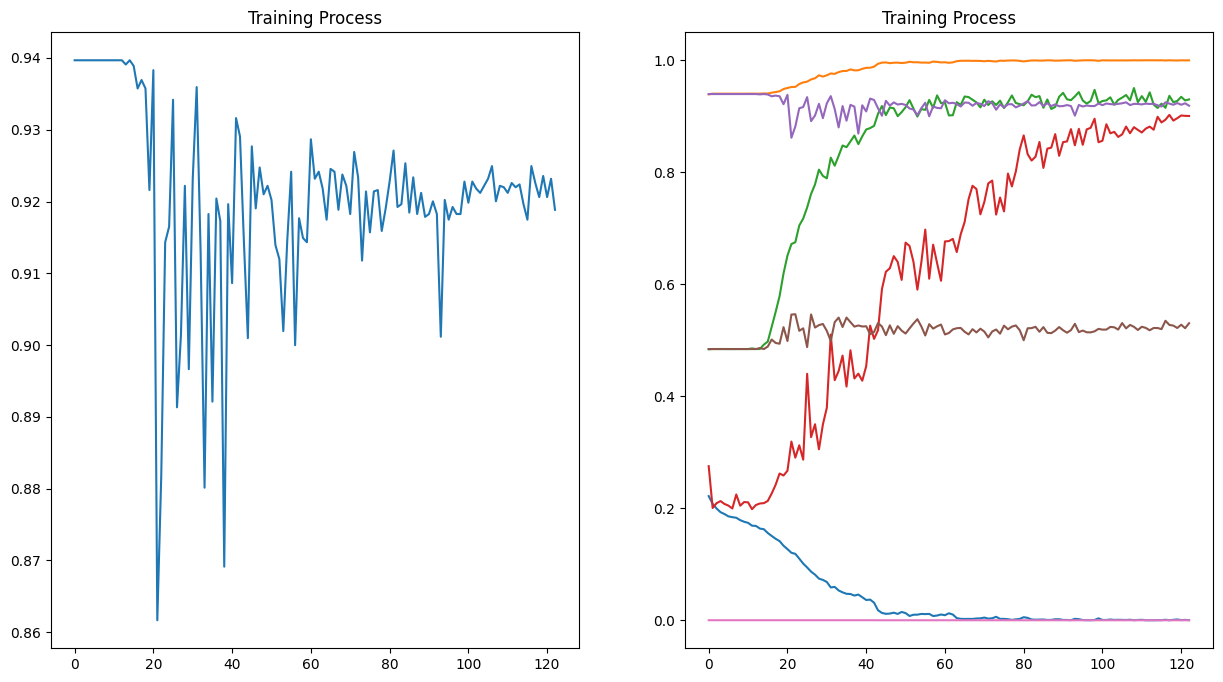

<Figure size 640x480 with 0 Axes>

In [23]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [24]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


160/160 [==============================] - 2s 7ms/step


0.8817056396148556

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

y_test_labels = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_test_labels, predictions)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test_labels, predictions))

print("Confusion Matrix:")
print(confusion_matrix(y_test_labels, predictions))


Accuracy: 0.8817056396148556
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      4782
           1       0.15      0.21      0.18       307

    accuracy                           0.88      5089
   macro avg       0.55      0.57      0.56      5089
weighted avg       0.90      0.88      0.89      5089

Confusion Matrix:
[[4422  360]
 [ 242   65]]


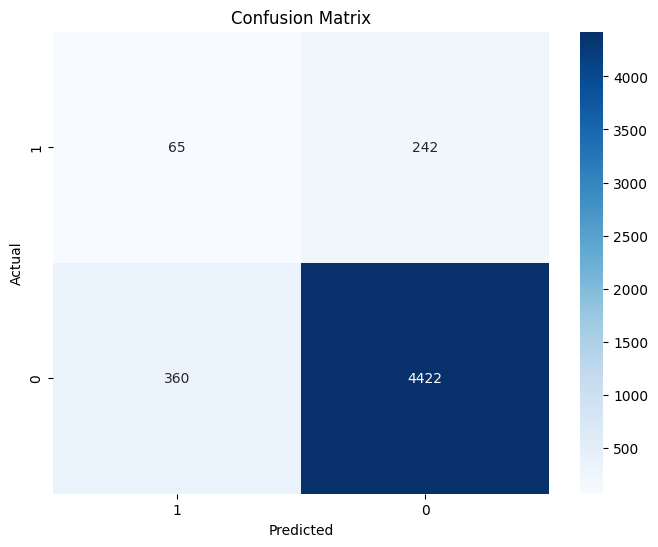

In [26]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

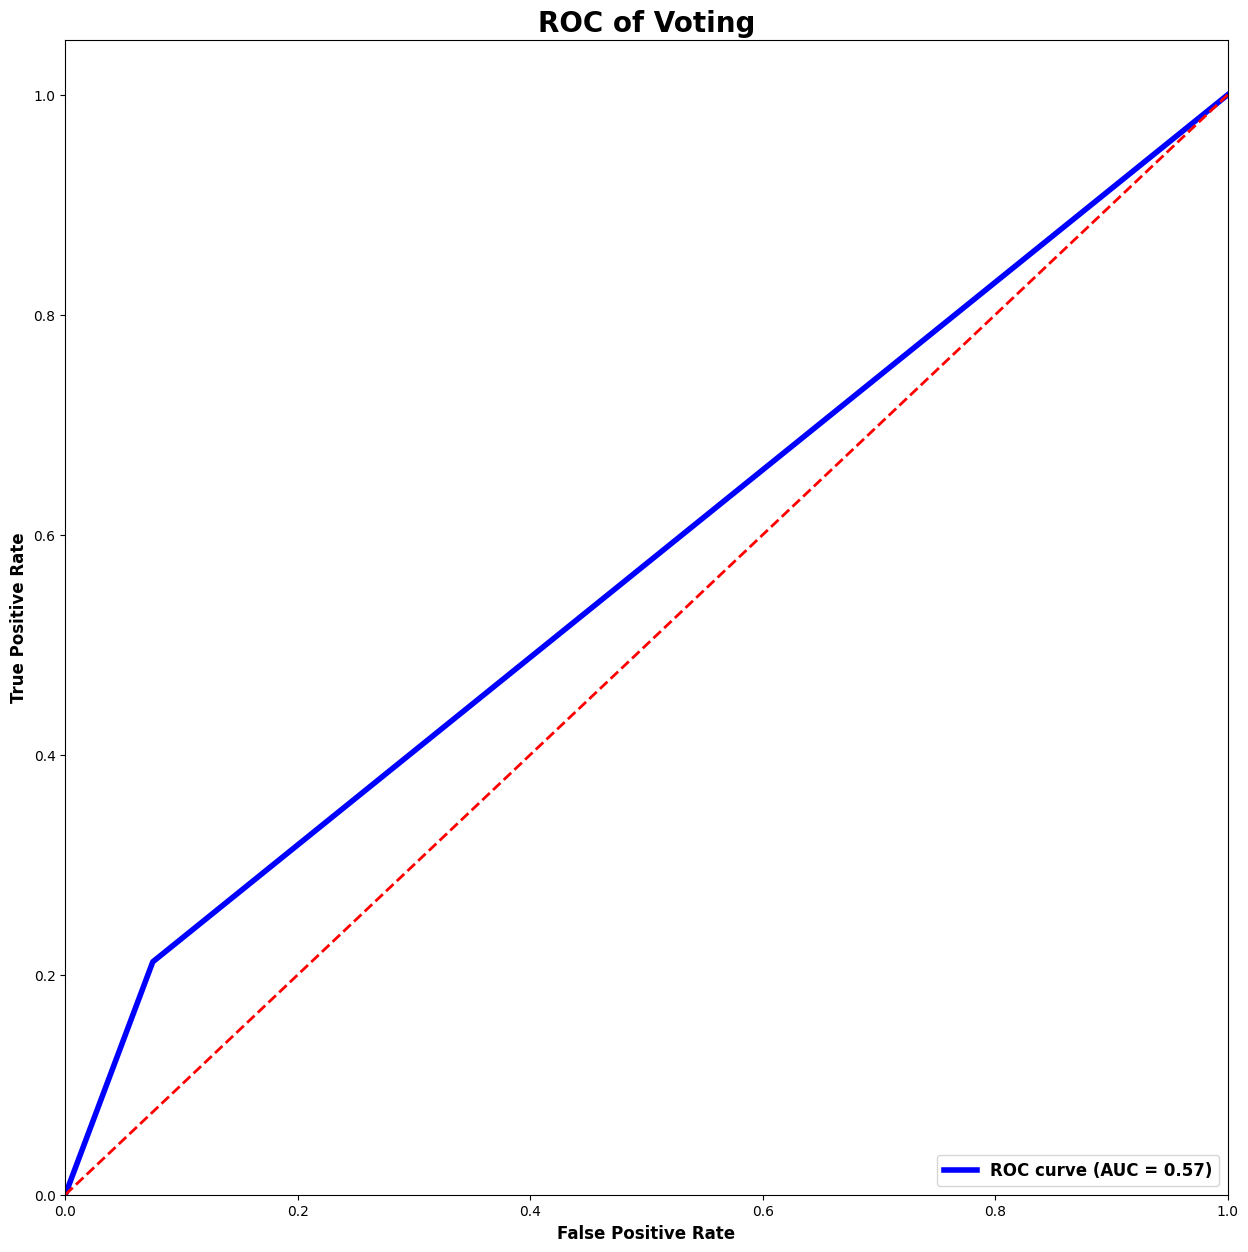

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [28]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [29]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    